In [1]:
#IPython extension to reload modules before executing user code.
#'autoreload' reloads modules automatically before entering the execution of code typed at the IPython prompt.
%load_ext autoreload
%autoreload 2
import os
os.environ['PYTHONHASHSEED'] = '0'

In [2]:
import os
os.environ['PYTHONHASHSEED'] = '0'
import gpustat

#select the best free GPU on the nvidia card
stats = gpustat.GPUStatCollection.new_query()
ids = map(lambda gpu: int(gpu.entry['index']), stats)
ratios = map(lambda gpu: float(gpu.entry['memory.used'])/float(gpu.entry['memory.total']), stats)
bestGPU = min(zip(ids, ratios), key=lambda x: x[1])[0]
bestGPU = 1

print("setGPU: Setting GPU to: {}".format(bestGPU))
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = str(bestGPU)

'''
#set memory usage to 0.5
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.33
set_session(tf.Session(config=config))'''

setGPU: Setting GPU to: 1


'\n#set memory usage to 0.5\nfrom keras.backend.tensorflow_backend import set_session\nimport tensorflow as tf\nconfig = tf.ConfigProto()\nconfig.gpu_options.per_process_gpu_memory_fraction = 0.33\nset_session(tf.Session(config=config))'

In [3]:
!pip install -q sklearn
import collections
import numpy as np, numpy
from keract import get_activations, display_activations
import keras
from keras import backend as K
from keras import optimizers, regularizers
from keras.callbacks import LearningRateScheduler
from keras.datasets import cifar10, cifar100 # we can use also cifar100
from keras.layers import Input, BatchNormalization, AveragePooling2D, ZeroPadding2D, LeakyReLU, GlobalAveragePooling2D, Dense, Flatten, Activation, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.models import Sequential, load_model, Model
from keras.regularizers import l2
from keras.utils import plot_model, to_categorical
from keras.utils.vis_utils import model_to_dot
import matplotlib.pyplot as plt
import scipy
import sklearn
import sklearn.metrics
import sys
#sys.executable
#sys.path
import time
from IPython.display import SVG

Using TensorFlow backend.


In [4]:
def normalize(x, mean, std):
    # This function normalizes inputs for zero mean and unit variance to speed up learning.
    
    # In case std = 0, we add eps = 1e-7
    eps = K.epsilon()
    x = (x-mean)/(std+eps)
    return x
  
def import_cifar(dataset):
    if dataset == 10:
        (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    elif dataset == 100:
        (x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')

    # By default, they are uint8 but we need them float to normalize them
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    
    # Calculating the mean and standard deviation of the training data
    mean = np.mean(x_train, axis=(0, 1, 2, 3))
    std = np.std(x_train, axis=(0, 1, 2, 3))
    
    # Normalizing 
    x_train = normalize(x_train, mean, std)
    x_test = normalize(x_test, mean, std)

    y_train = to_categorical(y_train, num_classes=dataset)
    y_test = to_categorical(y_test,  num_classes=dataset)
    
    return (x_train, y_train), (x_test, y_test)

In [5]:
# LOAD DATABase
num_classes = 10
(x_train, y_train), (x_test, y_test) = import_cifar(num_classes)

In [6]:
# Architecture taken from https://github.com/geifmany/cifar-vgg
# BatchNormalization before activations
def VGG16_beta(input_shape, num_classes, weight_decay):
    
    model = Sequential([
        
        #0
        Conv2D(64, (3, 3), padding='same', input_shape=input_shape, kernel_regularizer=regularizers.l2(weight_decay)),
        BatchNormalization(scale=False, center=False),
        Activation('relu'),
        #Dropout(0.3),
        
        #4
        Conv2D(64, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)),
        BatchNormalization(scale=False, center=False),
        Activation('relu'),
        
        MaxPooling2D(pool_size=(2, 2)),
        
        #8
        Conv2D(128, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)),
        BatchNormalization(scale=False, center=False),
        Activation('relu'),
        #Dropout(0.4),
        
        #12
        Conv2D(128, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)),
        BatchNormalization(scale=False, center=False),
        Activation('relu'),
        
        MaxPooling2D(pool_size=(2, 2)),
        
        #16
        Conv2D(256, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)),
        BatchNormalization(scale=False, center=False),
        Activation('relu'),
        #Dropout(0.4),
        
        #20
        Conv2D(256, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)),
        BatchNormalization(scale=False, center=False),
        Activation('relu'),
        #Dropout(0.4),
        
        #24
        Conv2D(256, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)),
        BatchNormalization(scale=False, center=False),
        Activation('relu'),
        
        MaxPooling2D(pool_size=(2, 2)),
        
        #28
        Conv2D(512, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)),
        BatchNormalization(scale=False, center=False),
        Activation('relu'),
        #Dropout(0.4),
        
        #32
        Conv2D(512, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)),
        BatchNormalization(scale=False, center=False),
        Activation('relu'),
        #Dropout(0.4),
        
        #36
        Conv2D(512, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)),
        BatchNormalization(scale=False, center=False),
        Activation('relu'),
        
        MaxPooling2D(pool_size=(2, 2)),
        
        #40
        Conv2D(512, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)),
        BatchNormalization(scale=False, center=False),
        Activation('relu'),
        #Dropout(0.4),
        
        #44
        Conv2D(512, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)),
        BatchNormalization(scale=False, center=False),
        Activation('relu'),
        #Dropout(0.4),
        
        #48
        Conv2D(512, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)),
        BatchNormalization(scale=False, center=False),
        Activation('relu'),
        
        MaxPooling2D(pool_size=(2, 2)),
        #Dropout(0.5),
        
        Flatten(),
        #54
        Dense(512, kernel_regularizer=regularizers.l2(weight_decay)),
        BatchNormalization(scale=False, center=False),
        Activation('relu'),
        
        #Dropout(0.5),
        #58
        Dense(num_classes, kernel_regularizer=regularizers.l2(weight_decay)),
        BatchNormalization(scale=False, center=False),
        Activation('softmax')
    ])

    return model

# Architecture taken from https://github.com/geifmany/cifar-vgg
# Weight decay and Dropout have been removed
# BatchNormalization before activations
def VGG16_Vanilla_beta(input_shape, num_classes):
    model = Sequential([
        
        #0
        Conv2D(64, (3, 3), padding='same', input_shape=input_shape),
        BatchNormalization(scale=False, center=False),
        Activation('relu'),
        
        #3
        Conv2D(64, (3, 3), padding='same'),
        BatchNormalization(scale=False, center=False),
        Activation('relu'),
        
        MaxPooling2D(pool_size=(2, 2)),
        
        #7
        Conv2D(128, (3, 3), padding='same'),
        BatchNormalization(scale=False, center=False),
        Activation('relu'),
        
        #10
        Conv2D(128, (3, 3), padding='same'),
        BatchNormalization(scale=False, center=False),
        Activation('relu'),
        
        MaxPooling2D(pool_size=(2, 2)),
        
        #14
        Conv2D(256, (3, 3), padding='same'),
        BatchNormalization(scale=False, center=False),
        Activation('relu'),
        
        #17
        Conv2D(256, (3, 3), padding='same'),
        BatchNormalization(scale=False, center=False),
        Activation('relu'),
        
        #20
        Conv2D(256, (3, 3), padding='same'),
        BatchNormalization(scale=False, center=False),
        Activation('relu'),
        
        MaxPooling2D(pool_size=(2, 2)),
        
        #24
        Conv2D(512, (3, 3), padding='same'),
        BatchNormalization(scale=False, center=False),
        Activation('relu'),
        
        #27
        Conv2D(512, (3, 3), padding='same'),
        BatchNormalization(scale=False, center=False),
        Activation('relu'),
        
        #30
        Conv2D(512, (3, 3), padding='same'),
        BatchNormalization(scale=False, center=False),
        Activation('relu'),
        
        MaxPooling2D(pool_size=(2, 2)),
        
        #34
        Conv2D(512, (3, 3), padding='same'),
        BatchNormalization(scale=False, center=False),
        Activation('relu'),
        
        #37
        Conv2D(512, (3, 3), padding='same'),
        BatchNormalization(scale=False, center=False),
        Activation('relu'),
        
        #40
        Conv2D(512, (3, 3), padding='same'),
        BatchNormalization(scale=False, center=False),
        Activation('relu'),
        
        MaxPooling2D(pool_size=(2, 2)),
        
        Flatten(),
        #45
        Dense(512),
        BatchNormalization(scale=False, center=False),
        Activation('relu'),
        
        #48
        Dense(num_classes),
        BatchNormalization(scale=False, center=False),
        Activation('softmax')
    ])
    return model


In [7]:
# LOAD huge MODELS
modelB = VGG16_Vanilla_beta(input_shape=(32,32,3), num_classes=10) #without Weight Decay but batchNorm before activation
modelC = VGG16_beta(input_shape=(32,32,3), num_classes=10, weight_decay=0.005) #with Weight Decay, and batchNorm before activation
modelD = VGG16_Vanilla_beta(input_shape=(32,32,3), num_classes=10) #without Weight Decay, but batchNorm before activation and with layca
modelE = VGG16_Vanilla_beta(input_shape=(32,32,3), num_classes=10) #with layca but with a bad LR

modelB.load_weights("../weights/1/vgg16_vanilla_beta/final/weights-final.hdf5") #vgg16-vanilla-beta
modelC.load_weights("../weights/1/vgg16_beta/final/weights-final.hdf5") #vgg16-beta
modelD.load_weights("../weights/1/vgg16_vanilla_layca/final/weights-final.hdf5") #vgg16-vanilla-layca
modelE.load_weights("../weights/3/vgg16_vanilla_layca_bad/final/weights-final.hdf5") #vgg16-vanilla-layca-bad

sgd = optimizers.SGD(lr=0.2, momentum=0.9, nesterov=True)
modelB.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
modelC.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
modelD.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
modelE.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [8]:
List_of_Layers_B = [
'conv2d_1/BiasAdd:0', 
'conv2d_2/BiasAdd:0',
'max_pooling2d_1/MaxPool:0',
'conv2d_3/BiasAdd:0', 
'conv2d_4/BiasAdd:0', 
'max_pooling2d_2/MaxPool:0',
'conv2d_5/BiasAdd:0', 
'conv2d_6/BiasAdd:0',  
'conv2d_7/BiasAdd:0', 
'max_pooling2d_3/MaxPool:0', 
'conv2d_8/BiasAdd:0',  
'conv2d_9/BiasAdd:0', 
'conv2d_10/BiasAdd:0', 
'max_pooling2d_4/MaxPool:0', 
'conv2d_11/BiasAdd:0',    
'conv2d_12/BiasAdd:0',
'conv2d_13/BiasAdd:0', 
'max_pooling2d_5/MaxPool:0', 
'dense_1/BiasAdd:0', 
'dense_2/BiasAdd:0']
List_of_Layers_C = [
'conv2d_14/BiasAdd:0', 
'conv2d_15/BiasAdd:0',
'max_pooling2d_6/MaxPool:0',
'conv2d_16/BiasAdd:0', 
'conv2d_17/BiasAdd:0', 
'max_pooling2d_7/MaxPool:0',
'conv2d_18/BiasAdd:0', 
'conv2d_19/BiasAdd:0',  
'conv2d_20/BiasAdd:0', 
'max_pooling2d_8/MaxPool:0', 
'conv2d_21/BiasAdd:0',  
'conv2d_22/BiasAdd:0', 
'conv2d_23/BiasAdd:0', 
'max_pooling2d_9/MaxPool:0', 
'conv2d_24/BiasAdd:0',    
'conv2d_25/BiasAdd:0',
'conv2d_26/BiasAdd:0', 
'max_pooling2d_10/MaxPool:0', 
'dense_3/BiasAdd:0', 
'dense_4/BiasAdd:0']
List_of_Layers_D = [
'conv2d_27/BiasAdd:0', 
'conv2d_28/BiasAdd:0',
'max_pooling2d_11/MaxPool:0',
'conv2d_29/BiasAdd:0', 
'conv2d_30/BiasAdd:0', 
'max_pooling2d_12/MaxPool:0',
'conv2d_31/BiasAdd:0', 
'conv2d_32/BiasAdd:0',  
'conv2d_33/BiasAdd:0', 
'max_pooling2d_13/MaxPool:0', 
'conv2d_34/BiasAdd:0',  
'conv2d_35/BiasAdd:0', 
'conv2d_36/BiasAdd:0', 
'max_pooling2d_14/MaxPool:0', 
'conv2d_37/BiasAdd:0',    
'conv2d_38/BiasAdd:0',
'conv2d_39/BiasAdd:0', 
'max_pooling2d_15/MaxPool:0', 
'dense_5/BiasAdd:0', 
'dense_6/BiasAdd:0']
List_of_Layers_E = [
'conv2d_40/BiasAdd:0', 
'conv2d_41/BiasAdd:0',
'max_pooling2d_16/MaxPool:0',
'conv2d_42/BiasAdd:0', 
'conv2d_43/BiasAdd:0', 
'max_pooling2d_17/MaxPool:0',
'conv2d_44/BiasAdd:0', 
'conv2d_45/BiasAdd:0',  
'conv2d_46/BiasAdd:0', 
'max_pooling2d_18/MaxPool:0', 
'conv2d_47/BiasAdd:0',  
'conv2d_48/BiasAdd:0', 
'conv2d_49/BiasAdd:0', 
'max_pooling2d_19/MaxPool:0', 
'conv2d_50/BiasAdd:0',    
'conv2d_51/BiasAdd:0',
'conv2d_52/BiasAdd:0', 
'max_pooling2d_20/MaxPool:0', 
'dense_7/BiasAdd:0', 
'dense_8/BiasAdd:0', 
 ]

In [9]:
# EVALUATION
# Final evaluation of the models
scoresB = modelB.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scoresB[0])
print('Test accuracy:', scoresB[1])
print("%.2f%% : Model B with BatchNorm before activation CNN Error" % (100-scoresB[1]*100)) # 83%
scoresC = modelC.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scoresC[0])
print('Test accuracy:', scoresC[1])
print("%.2f%% : Model C with Weightdecay Error" % (100-scoresC[1]*100)) # 86%
scoresD = modelD.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scoresD[0])
print('Test accuracy:', scoresD[1])
print("%.2f%% : Model D with layca Error"  % (100-scoresD[1]*100)) # 87%
scoresE = modelE.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scoresE[0])
print('Test accuracy:', scoresE[1])
print("%.2f%% : Model E with layca with bad LR Error" % (100-scoresE[1]*100)) # 71%

10000/10000 [==============================] - 4s 427us/step
Test loss: 0.741067469215393
Test accuracy: 0.8364
16.36% : Model B with BatchNorm before activation CNN Error
10000/10000 [==============================] - 3s 335us/step
Test loss: 0.7285478861808777
Test accuracy: 0.8614
13.86% : Model C with Weightdecay Error
10000/10000 [==============================] - 3s 300us/step
Test loss: 0.6406159608840942
Test accuracy: 0.8728
12.72% : Model D with layca Error
10000/10000 [==============================] - 3s 301us/step
Test loss: 1.0742266889572143
Test accuracy: 0.71
29.00% : Model E with layca with bad LR Error


In [72]:
# On regarde l'activation des pairs de neurones pour un echantillon test pris au hasard
Echantillon = []
nombreDImagesDActivation = 100
choix = np.random.choice(x_test.shape[0], nombreDImagesDActivation)
Echantillon = x_train[choix, :, : , :]

IMB = get_activations(modelB, Echantillon)
IMC = get_activations(modelC, Echantillon)
IMD = get_activations(modelD, Echantillon)
IME = get_activations(modelE, Echantillon)
# on affiche les noms des differentes couches
#print(IMB.keys())
#modelB.summary()

In [73]:
def PATH(IM, nameOfTheLayer):
    #count the number of pathologic neurons
    pathologicCount = 0
    
    numNeurons = numpy.size(IM[nameOfTheLayer][0])
    #print('numNeurons : ', str(numNeurons)) # 65536 neurones
    #print('nombreDImagesDActivation : ', str(nombreDImagesDActivation)) # 100 images d'activations
    
    MatrixActivation = np.zeros((numNeurons,nombreDImagesDActivation))
    
    indexActi = -1
    for activation in IM[nameOfTheLayer]:   # on a les activations pour de la couche
        
        indexActi = indexActi + 1
        
        #print(len(activation)) # image_X
        #print(len(activation[0])) # image_Y
        #print(len(activation[0][0])) # les 64 filtres de la couche convolutive
        activation = activation.flatten() # on a tous nos neurones sur un seul vecteur
        
        for i in range(numNeurons):
            MatrixActivation[i][indexActi] = activation[i]

    #on normalise les activations
    MatrixActivation_normed = MatrixActivation / MatrixActivation.max(axis=0)
    
    #print(len(MatrixActivation_normed)) #nombre de neurones
    #print(len(MatrixActivation_normed[0])) # nombre d'activation
    
    for j in range(numNeurons):
        if all([ v == 0 for v in MatrixActivation_normed[:][j] ]):
            pathologicCount = pathologicCount + 1

    return pathologicCount, numNeurons


The history saving thread hit an unexpected error (OperationalError('database is locked',)).History will not be written to the database.


In [74]:
# initialization of variables for the plot of the pathologic count
PCountB = []
PCountC = []
PCountD = []
PCountE = []

In [75]:
print('number of images used for see the activations : '+str(nombreDImagesDActivation) + '\n')

print('\n Model B :\n')
for layer in List_of_Layers_B:
    #nom de la couche
    print('couche :', str(layer))
    pathologicCount, numNeurons = PATH(IMB, layer)
    PCountB.append(pathologicCount/numNeurons)
    print('pathologic count: ', str(pathologicCount),' on ',str(numNeurons))
        
print('\n Model C :\n')
for layer in List_of_Layers_C:
    #nom de la couche
    print('couche :', str(layer))
    pathologicCount, numNeurons = PATH(IMC, layer)
    PCountC.append(pathologicCount/numNeurons)
    print('pathologic count: ', str(pathologicCount),' on ',str(numNeurons))
        
print('\n Model D :\n')
for layer in List_of_Layers_D:
    #nom de la couche
    print('couche :', str(layer)) 
    pathologicCount, numNeurons = PATH(IMD, layer)
    PCountD.append(pathologicCount/numNeurons)
    print('pathologic count: ', str(pathologicCount),' on ',str(numNeurons))
        
print('\n Model E :\n')
for layer in List_of_Layers_E:
    #nom de la couche
    print('couche :', str(layer))
    pathologicCount, numNeurons = PATH(IME, layer)
    PCountE.append(pathologicCount/numNeurons)
    print('pathologic count: ', str(pathologicCount),' on ',str(numNeurons))

number of images used for see the activations : 100


 Model B :

couche : conv2d_1/BiasAdd:0
pathologic count:  0  on  65536
couche : conv2d_2/BiasAdd:0
pathologic count:  0  on  65536
couche : max_pooling2d_1/MaxPool:0
pathologic count:  0  on  16384
couche : conv2d_3/BiasAdd:0
pathologic count:  0  on  32768
couche : conv2d_4/BiasAdd:0
pathologic count:  0  on  32768
couche : max_pooling2d_2/MaxPool:0
pathologic count:  0  on  8192
couche : conv2d_5/BiasAdd:0
pathologic count:  0  on  16384
couche : conv2d_6/BiasAdd:0
pathologic count:  0  on  16384
couche : conv2d_7/BiasAdd:0
pathologic count:  0  on  16384
couche : max_pooling2d_3/MaxPool:0
pathologic count:  0  on  4096
couche : conv2d_8/BiasAdd:0
pathologic count:  0  on  8192
couche : conv2d_9/BiasAdd:0
pathologic count:  0  on  8192
couche : conv2d_10/BiasAdd:0
pathologic count:  0  on  8192
couche : max_pooling2d_4/MaxPool:0
pathologic count:  2  on  2048
couche : conv2d_11/BiasAdd:0
pathologic count:  0  on  2048
couche : co

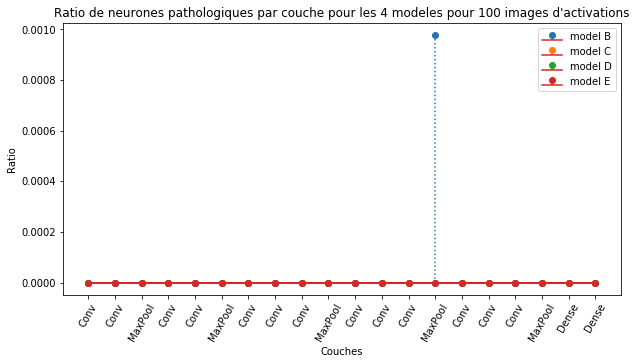

In [76]:
# plot:
fig = plt.figure(figsize=(10, 5))
nombreCouches = 20
x = range(nombreCouches)

markerline, stemlines, baseline = plt.stem(x, PCountB, markerfmt='o', label='model B')
plt.setp(stemlines, 'color', plt.getp(markerline,'color'))
plt.setp(stemlines, 'linestyle', 'dotted')

markerline, stemlines, baseline = plt.stem(x, PCountC, markerfmt='o', label='model C')
plt.setp(stemlines, 'color', plt.getp(markerline,'color'))
plt.setp(stemlines, 'linestyle', 'dotted')

markerline, stemlines, baseline = plt.stem(x, PCountD, markerfmt='o', label='model D')
plt.setp(stemlines, 'color', plt.getp(markerline,'color'))
plt.setp(stemlines, 'linestyle', 'dotted')

markerline, stemlines, baseline = plt.stem(x, PCountE, markerfmt='o', label='model E')
plt.setp(stemlines, 'color', plt.getp(markerline,'color'))
plt.setp(stemlines, 'linestyle', 'dotted')

plt.legend()
plt.xlabel('Couches')
plt.xticks(np.arange(nombreCouches), ('Conv','Conv','MaxPool','Conv','Conv','MaxPool','Conv','Conv','Conv','MaxPool','Conv','Conv','Conv','MaxPool','Conv','Conv','Conv','MaxPool','Dense','Dense'), rotation=60)
plt.ylabel('Ratio')
plt.title('Ratio de neurones pathologiques par couche pour les 4 modeles pour '+str(nombreDImagesDActivation)+' images d\'activations')
plt.show()
fig.savefig('V6_PathologicCount_100_test.png', dpi=100)